In [78]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import scgen

In [2]:
import torch
import random

# note that this does not make the result reproducible

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [73]:
from utils import plot_iroot, comp_kde, kdeplot, kdeplot2, get_kde_eval, norm

In [9]:
d1 = ad.read_h5ad("data/dynchro1_slingshot_processed.h5ad")
d2 = ad.read_h5ad("data/dynchro2_slingshot_processed.h5ad")
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC': 'sC_batch'})

d1.X = d1.layers["X"]
d2.X = d2.layers["X"]

In [10]:
datasets_mapping = {
    "control": d1,
    "premature stop": d2
}
datasets = ad.concat(datasets_mapping, label="batch")
datasets.obs_names_make_unique()

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# scGen, using sC and sC_batch

In [11]:
scgen.SCGEN.setup_anndata(datasets, batch_key="batch", labels_key="milestones")
model = scgen.SCGEN(datasets)
model.train(
    max_epochs=100,
    batch_size=16,
    early_stopping=True,
    early_stopping_patience=25,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1544.724. Signaling Trainer to stop.


In [12]:
corrected_adata = model.batch_removal()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/home/louise/Work/scgen/scgen/_scgen.py:265: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  batch_list[study].X = delta + batch_list[study].X
/home/louise/Work/scgen/scgen/_scgen.py:266: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  temp_cell[batch_ind[study]].X = batch_list[study].X
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indice

In [13]:
corrected_adata.obsm["corrected_latent"]

array([[ 1.3765217 ,  2.692766  , -0.7425735 , ...,  0.48724383,
         0.61884284,  4.2785707 ],
       [ 2.2021525 ,  1.4930831 ,  0.09823342, ..., -0.8001553 ,
         1.3027594 ,  0.6515683 ],
       [ 1.54443   ,  2.5802662 ,  0.9685253 , ...,  0.58963424,
        -3.4661078 , -0.59805596],
       ...,
       [ 4.1428504 , -0.58463955, -1.0496395 , ..., -1.3794494 ,
        -0.21163492,  3.6527784 ],
       [ 3.9182525 , -1.9510434 ,  0.71252865, ..., -2.346292  ,
         0.5890417 , -1.1162663 ],
       [-2.275321  ,  1.2492859 ,  1.620203  , ..., -3.394566  ,
        -0.75730747,  0.48088366]], shape=(1822, 100), dtype=float32)

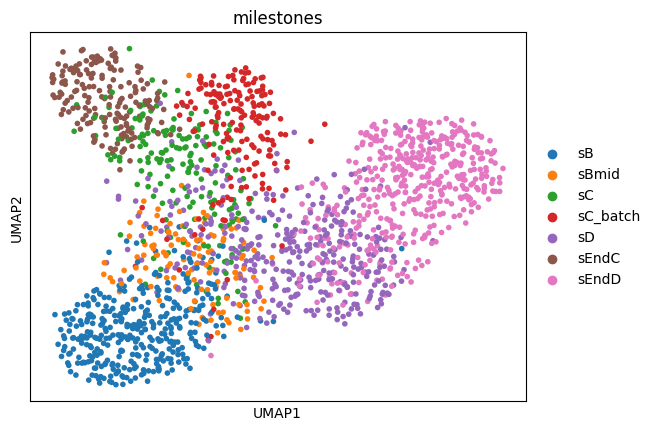

In [14]:
sc.pp.neighbors(corrected_adata, use_rep="corrected_latent")
sc.tl.umap(corrected_adata)
sc.pl.umap(corrected_adata, color = 'milestones', wspace = 0.4)

/tmp/ipykernel_10044/2625296932.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(corrected_adata, resolution=1.4, key_added="leiden1")


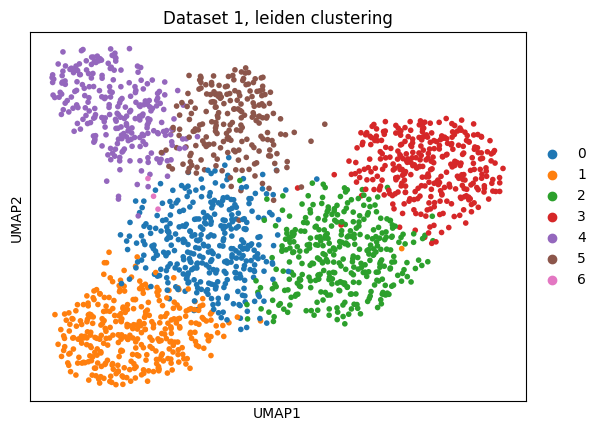

In [15]:
sc.tl.leiden(corrected_adata, resolution=1.4, key_added="leiden1")
sc.pl.umap(corrected_adata, color='leiden1', title="Dataset 1, leiden clustering")

In [16]:
corrected_adata.write_h5ad("data/scgen1.h5ad")

## Pseudotime

In [53]:
scgen1_result = ad.read_h5ad("data/scgen1_slingshot.h5ad")
scgen1_result

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'concat_batch', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2', 'slingPseudotime_3'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent'
    layers: 'X'
    obsp: 'connectivities', 'distances'

In [54]:
scgen1_result.obsm["X_corrected_latent"] = scgen1_result.obsm["corrected_latent"]

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


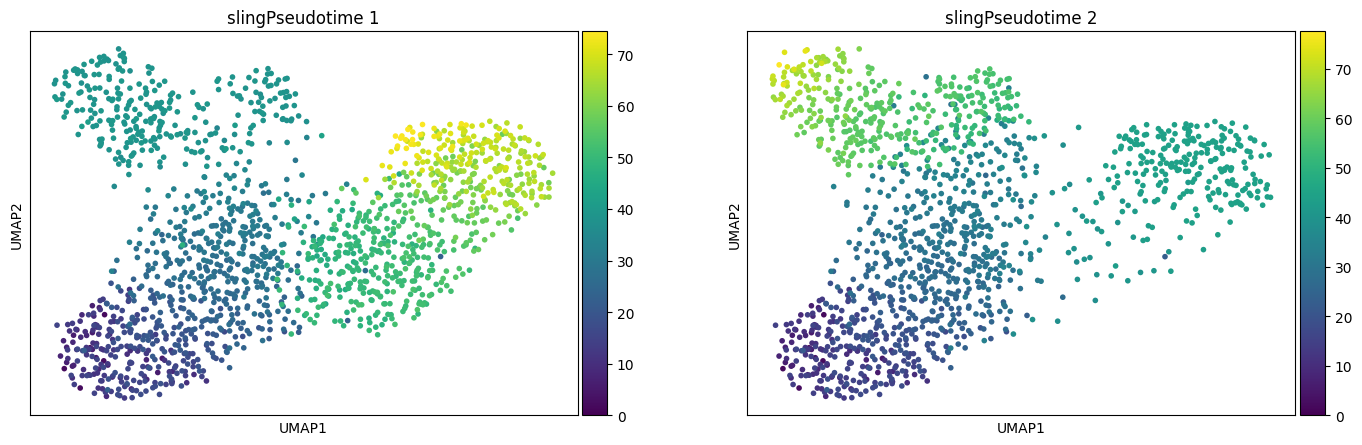

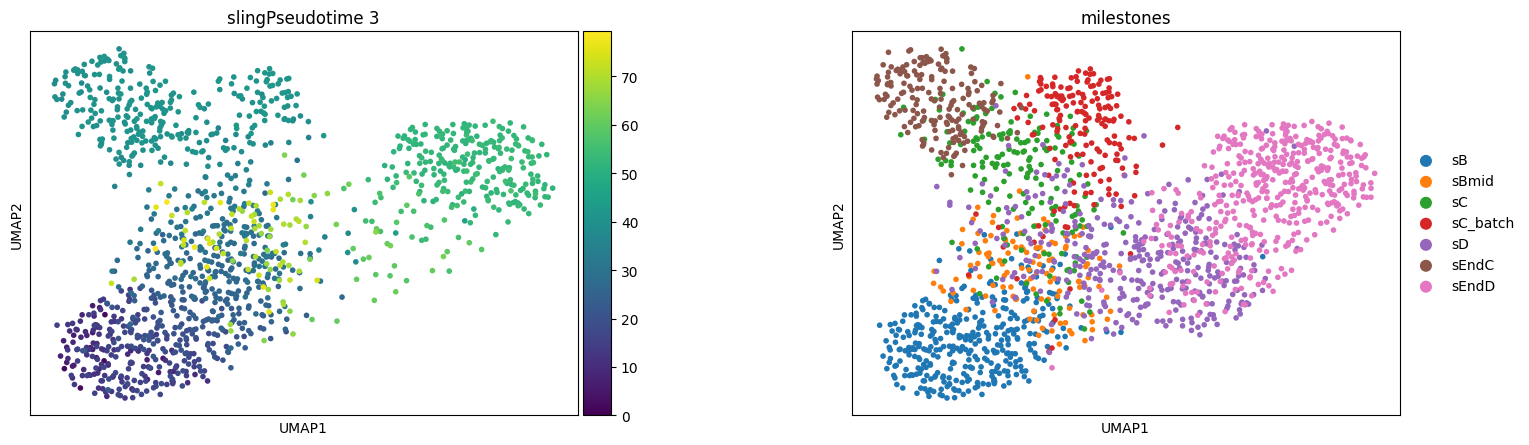

In [56]:
sc.pl.scatter(scgen1_result, basis = "umap", color = ["slingPseudotime_1", "slingPseudotime_2"])
sc.pl.scatter(scgen1_result, basis = "umap", color = ["slingPseudotime_3", "milestones"])

In [57]:
# select all cells in slingPseudotime_2 that are not NA there
clin = scgen1_result[~scgen1_result.obs["slingPseudotime_2"].isna()]
dlin = scgen1_result[~scgen1_result.obs["slingPseudotime_1"].isna()]

In [58]:
%matplotlib inline

View of AnnData object with n_obs × n_vars = 180 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'concat_batch', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2', 'slingPseudotime_3'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'X'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 178 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'concat_batch', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2', 'slingPseudotime_3'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden1', 'leiden1_colors', 'mil

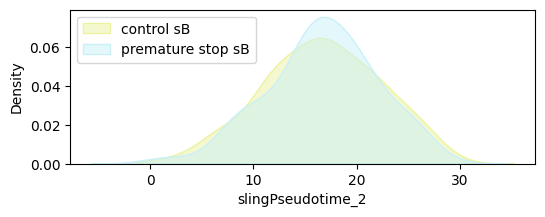

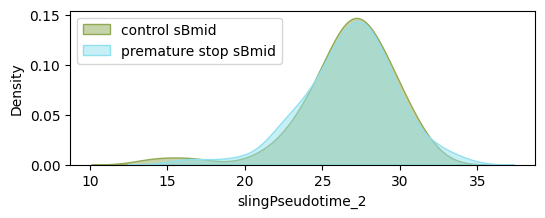

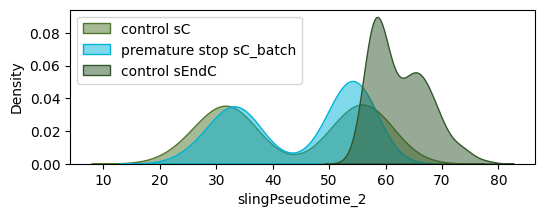

In [59]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(clin, "sB", time_column = "slingPseudotime_2", colors = ["#ecf39e", "#caf0f8"])
    comp_kde(clin, "sBmid",time_column = "slingPseudotime_2", colors = ["#90a955", "#90e0ef"])
    
    kdeplot2(clin, "control", "sC",time = "slingPseudotime_2", milestone_column = "milestones", color="#4f772d")
    kdeplot2(clin, "premature stop", "sC_batch",time = "slingPseudotime_2", milestone_column = "milestones", color="#00b4d8")
    kdeplot2(clin, "control", "sEndC", time = "slingPseudotime_2",milestone_column = "milestones", color="#31572c")
    plt.legend()

View of AnnData object with n_obs × n_vars = 180 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'concat_batch', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2', 'slingPseudotime_3'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'X'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 178 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'concat_batch', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2', 'slingPseudotime_3'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden1', 'leiden1_colors', 'mil

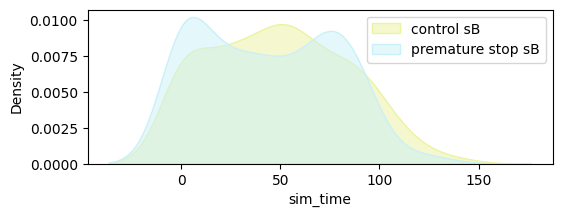

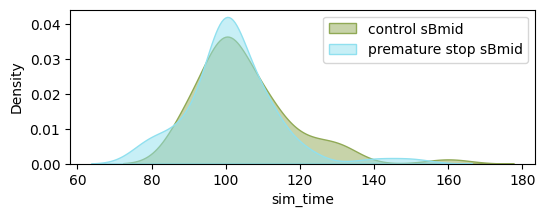

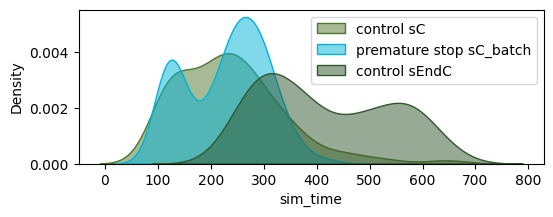

In [60]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(clin, "sB", colors = ["#ecf39e", "#caf0f8"], time_column="sim_time")
    comp_kde(clin, "sBmid", colors = ["#90a955", "#90e0ef"], time_column="sim_time")
    
    kdeplot2(clin, "control", "sC", milestone_column = "milestones", color="#4f772d", time="sim_time")
    kdeplot2(clin, "premature stop", "sC_batch", milestone_column = "milestones", color="#00b4d8", time="sim_time")
    kdeplot2(clin, "control", "sEndC", milestone_column = "milestones", color="#31572c",  time="sim_time")
    plt.legend()

In [80]:
clin_after = clin
dlin_after = dlin

# select all where linC is True
clin_before = scgen1_result[scgen1_result.obs.linC == "TRUE"]
dlin_before = scgen1_result[scgen1_result.obs.linD == "TRUE"]

In [81]:
cbx, cby, cbkde = get_kde_eval(norm(clin_before.obs.orig_linC_pseudotime), bandwith=0.1)
dbx, dby, dbkde = get_kde_eval(norm(dlin_before.obs.orig_linD_pseudotime), bandwith=0.1)

cax, cay, cakde = get_kde_eval(norm(clin_after.obs.slingPseudotime_2), bandwith=0.1)
dax, day, dakde = get_kde_eval(norm(dlin_after.obs.slingPseudotime_1), bandwith=0.1)

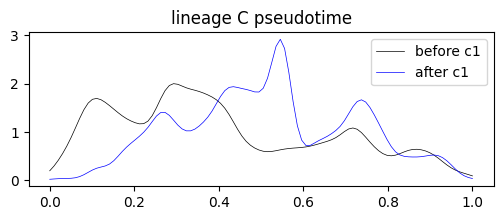

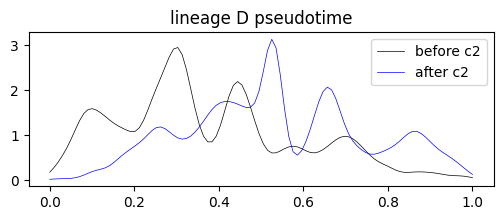

In [82]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(cbx, cby, color="black", lw=0.5, label="before c1")
ax.plot(cax, cay, color="blue", lw=0.5, label="after c1")
plt.title("lineage C pseudotime")
plt.legend()
plt.show()
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(dbx, dby, color="black", lw=0.5, label="before c2")
ax.plot(dax, day, color="blue", lw=0.5, label="after c2")
plt.title("lineage D pseudotime")
plt.legend()
plt.show()

In [83]:
c_wasserstein = scipy.stats.wasserstein_distance(cbx, cax, cby, cay)
print(f"Wasserstein distance before vs after C: {c_wasserstein}")
d_wasserstein = scipy.stats.wasserstein_distance(dbx, dax, dby, day)
print(f"Wasserstein distance before vs after D: {d_wasserstein}")

Wasserstein distance before vs after C: 0.11013402754600837
Wasserstein distance before vs after D: 0.16240993114125876


# scGen, using lineage labels

In [24]:
lin_cats = {
    "sB": "sB",
    "sBmid": "sBmid",
    "sC": "sC",
    "sC_batch": "sC",
    "sEndC": "sC",
    "sD": "sD",
    "sEndD": "sD",
}

d2_lin = d2.copy()
d1_lin = d1.copy()

d2_lin.obs["milestones"] = d2_lin.obs.milestones.map(lin_cats).astype("category")
d1_lin.obs["milestones"] = d1_lin.obs.milestones.map(lin_cats).astype("category")

dm_lin = {
    "control": d1_lin,
    "premature stop": d2_lin
}
dm_lin = ad.concat(dm_lin, label="batch")
dm_lin.obs_names_make_unique()

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [25]:
dm_lin.obs["milestones"]

cell1         sD
cell2         sD
cell3         sD
cell4         sD
cell5         sC
              ..
cell996-1     sC
cell997-1     sD
cell998-1     sD
cell999-1     sD
cell1000-1    sC
Name: milestones, Length: 1822, dtype: category
Categories (4, object): ['sB', 'sBmid', 'sC', 'sD']

In [51]:
dm_lin.obs

,step_ix,simulation_i,sim_time,milestones,leiden,dpt_pseudotime,orig_linD_pseudotime,orig_linC_pseudotime,linD,linC,batch,_scvi_batch,_scvi_labels
cell1,4972,62,150.083333,sD,0,0.183115,23.534008,23.849089,TRUE,TRUE,control,0,3
cell2,7919,98,460.083333,sD,4,0.616939,42.164078,NaN,TRUE,FALSE,control,0,3
cell3,54,1,380.083333,sD,4,0.655404,41.690671,NaN,TRUE,FALSE,control,0,3
cell4,2870,36,190.000000,sD,0,0.143597,20.238094,21.807524,TRUE,TRUE,control,0,3
cell5,4848,60,530.083333,sC,5,0.933513,NaN,57.245446,FALSE,TRUE,control,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell996-1,2138,27,160.000000,sC,0,0.352409,22.465927,29.337826,TRUE,TRUE,premature stop,1,2
cell997-1,4833,60,380.083333,sD,2,0.558616,35.284809,NaN,TRUE,FALSE,premature stop,1,3
cell998-1,2065,26,240.000000,sD,0,0.271343,21.402175,23.197623,TRUE,TRUE,premature stop,1,3
cell999-1,3755,47,130.083333,sD,0,0.280662,20.149078,21.857863,TRUE,TRUE,premature stop,1,3


In [26]:
scgen.SCGEN.setup_anndata(dm_lin, batch_key="batch", labels_key="milestones")
model_lin = scgen.SCGEN(dm_lin)
model_lin.train(
    max_epochs=100,
    batch_size=16,
    early_stopping=True,
    early_stopping_patience=25,
)
corrected_adata_lin = model_lin.batch_removal()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1538.791. Signaling Trainer to stop.
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/home/louise/Work/scgen/scgen/_scgen.py:265: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  batch_list[study].X = delta + batch_list[study].X
/home/louise/Work/scgen/scgen/_scgen.py:266: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  temp_cell[batch_ind[study]].X = batch_list[study].X
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indice

In [52]:
corrected_adata_lin.obs

,step_ix,simulation_i,sim_time,milestones,leiden,dpt_pseudotime,orig_linD_pseudotime,orig_linC_pseudotime,linD,linC,batch,_scvi_batch,_scvi_labels,leiden1
cell1,4972,62,150.083333,sD,0,0.183115,23.534008,23.849089,TRUE,TRUE,control,0,3,1
cell2,7919,98,460.083333,sD,4,0.616939,42.164078,NaN,TRUE,FALSE,control,0,3,3
cell3,54,1,380.083333,sD,4,0.655404,41.690671,NaN,TRUE,FALSE,control,0,3,3
cell4,2870,36,190.000000,sD,0,0.143597,20.238094,21.807524,TRUE,TRUE,control,0,3,0
cell5,4848,60,530.083333,sC,5,0.933513,NaN,57.245446,FALSE,TRUE,control,0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell996-1,2138,27,160.000000,sC,0,0.352409,22.465927,29.337826,TRUE,TRUE,premature stop,1,2,1
cell997-1,4833,60,380.083333,sD,2,0.558616,35.284809,NaN,TRUE,FALSE,premature stop,1,3,3
cell998-1,2065,26,240.000000,sD,0,0.271343,21.402175,23.197623,TRUE,TRUE,premature stop,1,3,0
cell999-1,3755,47,130.083333,sD,0,0.280662,20.149078,21.857863,TRUE,TRUE,premature stop,1,3,3


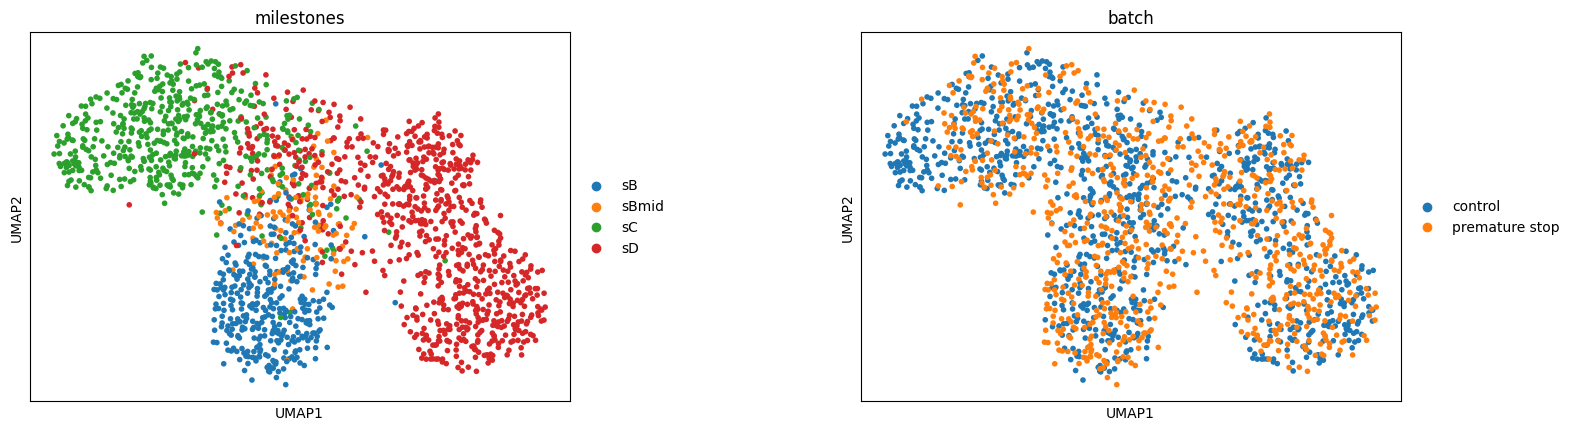

In [28]:
sc.pp.neighbors(corrected_adata_lin, use_rep="corrected_latent")
sc.tl.umap(corrected_adata_lin)
sc.pl.umap(corrected_adata_lin, color=['milestones', 'batch'], wspace=0.4)

<Axes: xlabel='x', ylabel='y'>

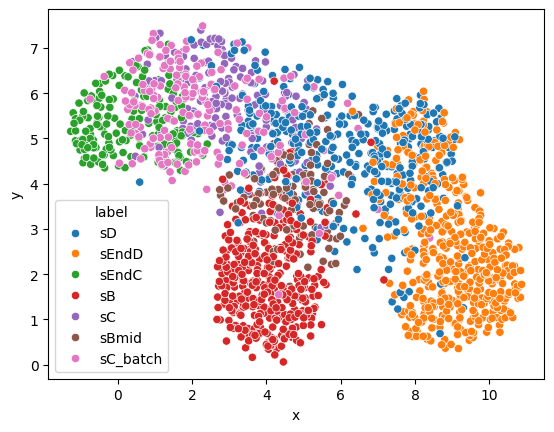

In [29]:
xvals = corrected_adata_lin.obsm["X_umap"][:, 0]
yvals = corrected_adata_lin.obsm["X_umap"][:, 1]
cats = np.concat((d1.obs["milestones"].values ,d2.obs["milestones"].values))

# create a DataFrame for the legend
legend_df = pd.DataFrame({
    "x": xvals,
    "y": yvals,
    "label": cats,
})

sns.scatterplot(
    data=legend_df,
    x="x",
    y="y",
    hue="label",
    legend=True,
)

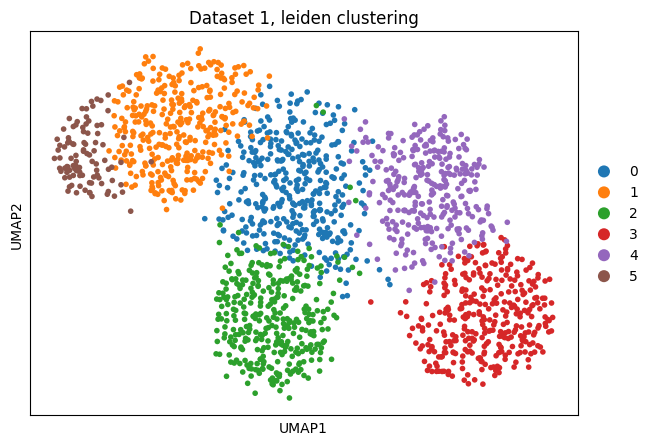

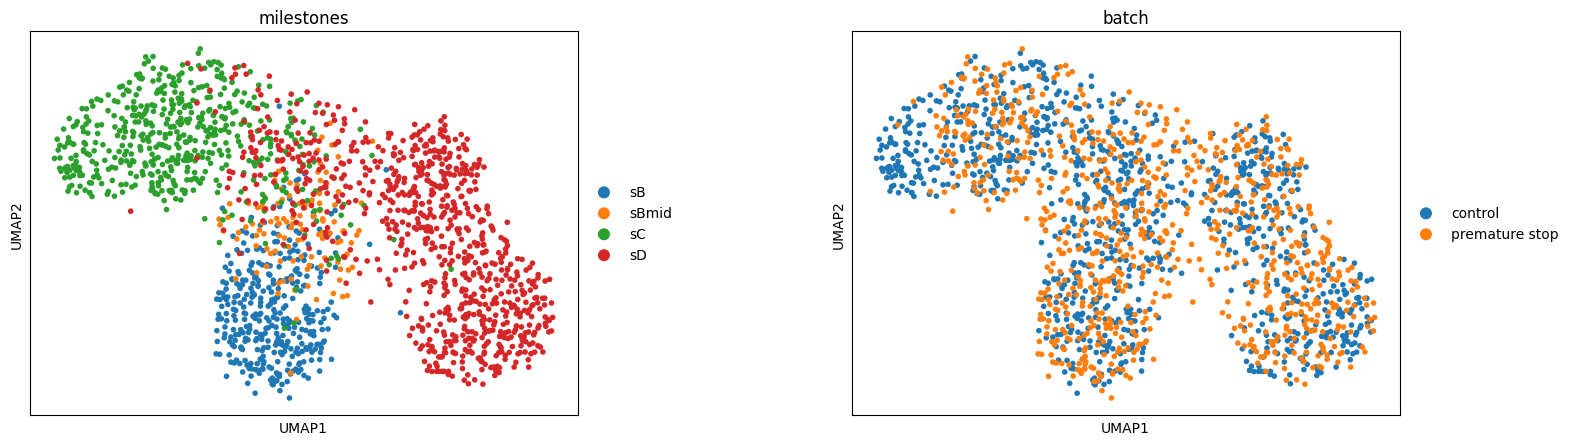

In [30]:
sc.tl.leiden(corrected_adata_lin, resolution=1, key_added="leiden1")
sc.pl.scatter(corrected_adata_lin, basis="umap", color='leiden1', title="Dataset 1, leiden clustering")
sc.pl.scatter(corrected_adata_lin, basis="umap", color=['milestones', 'batch'])

In [31]:
corrected_adata_lin.write_h5ad("data/scgen2.h5ad")

## Psuedotime

In [61]:
scgen2_result = ad.read_h5ad("data/scgen2_slingshot.h5ad")
scgen2_result

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent'
    layers: 'X'
    obsp: 'connectivities', 'distances'

In [62]:
scgen2_result.obsm["X_corrected_latent"] = scgen2_result.obsm["corrected_latent"]

In [63]:
scgen2_result

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'X'
    obsp: 'connectivities', 'distances'

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


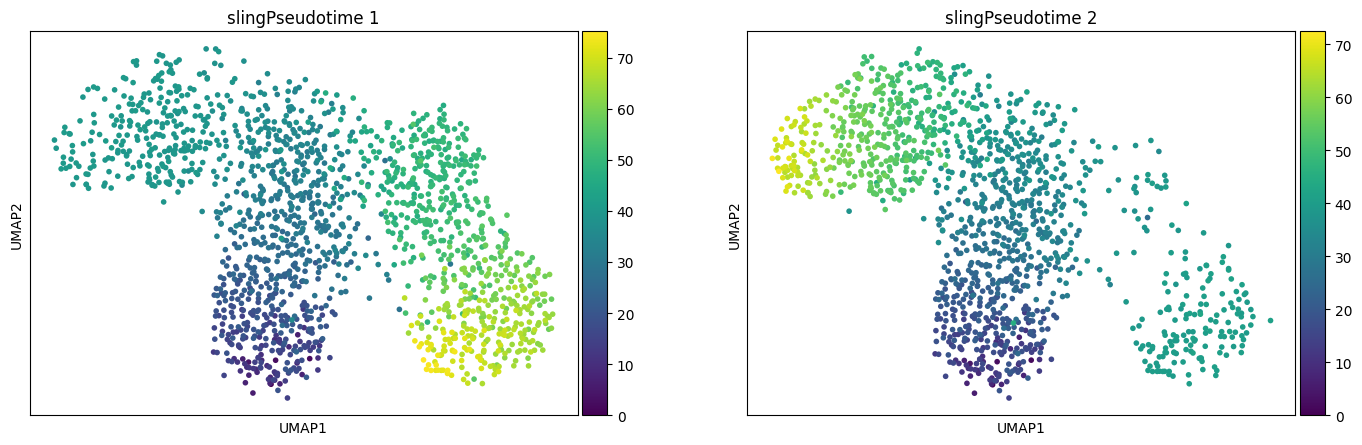

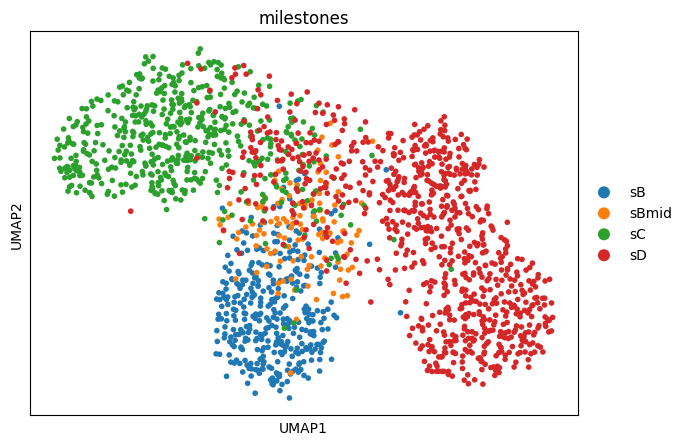

In [64]:
sc.pl.scatter(scgen2_result, basis = "umap", color = ["slingPseudotime_1", "slingPseudotime_2"])
sc.pl.scatter(scgen2_result, basis="umap", color = ["milestones"])

In [66]:
clin = scgen2_result[~scgen2_result.obs["slingPseudotime_2"].isna()]
dlin = scgen2_result[~scgen2_result.obs["slingPseudotime_1"].isna()]

View of AnnData object with n_obs × n_vars = 179 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'X'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 177 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    o

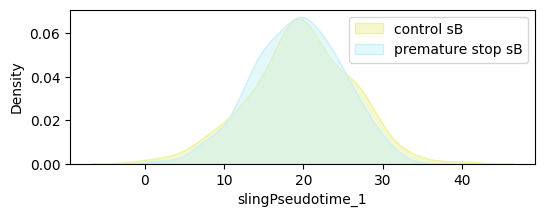

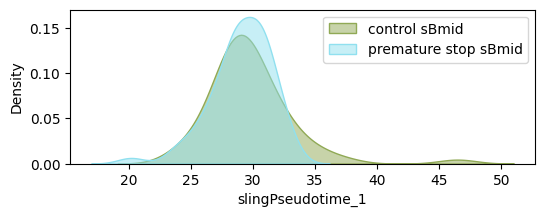

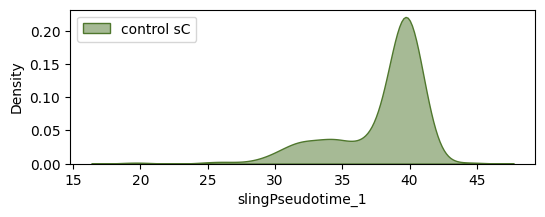

In [67]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(clin, "sB", time_column = "slingPseudotime_1", colors = ["#ecf39e", "#caf0f8"])
    comp_kde(clin, "sBmid",time_column = "slingPseudotime_1", colors = ["#90a955", "#90e0ef"])
    
    kdeplot2(clin, "control", "sC",time = "slingPseudotime_1", milestone_column = "milestones", color="#4f772d")
    kdeplot2(clin, "premature stop", "sC_batch",time = "slingPseudotime_1", milestone_column = "milestones", color="#00b4d8")
    kdeplot2(clin, "control", "sEndC", time = "slingPseudotime_1",milestone_column = "milestones", color="#31572c")
    plt.legend()

View of AnnData object with n_obs × n_vars = 179 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'X'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 177 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    o

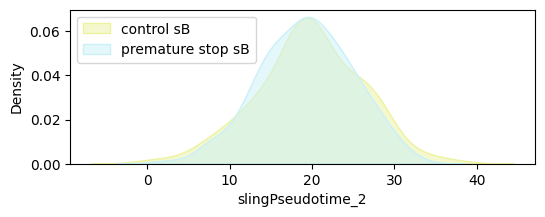

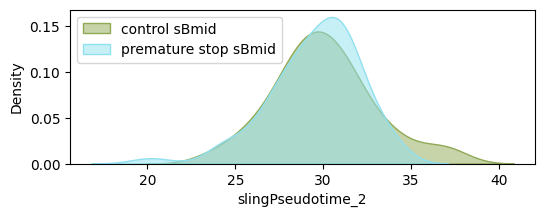

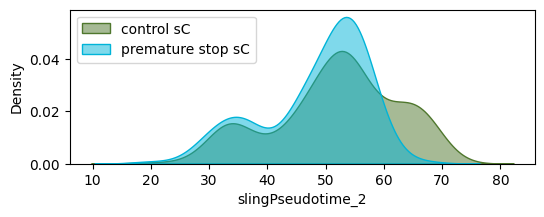

In [68]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(clin, "sB", time_column = "slingPseudotime_2", colors = ["#ecf39e", "#caf0f8"])
    comp_kde(clin, "sBmid",time_column = "slingPseudotime_2", colors = ["#90a955", "#90e0ef"])
    
    kdeplot2(clin, "control", "sC",time = "slingPseudotime_2", milestone_column = "milestones", color="#4f772d")
    kdeplot2(clin, "premature stop", "sC",time = "slingPseudotime_2", milestone_column = "milestones", color="#00b4d8")
    kdeplot2(clin, "control", "sEndC", time = "slingPseudotime_2",milestone_column = "milestones", color="#31572c")
    plt.legend()

View of AnnData object with n_obs × n_vars = 179 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'X'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 177 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    o

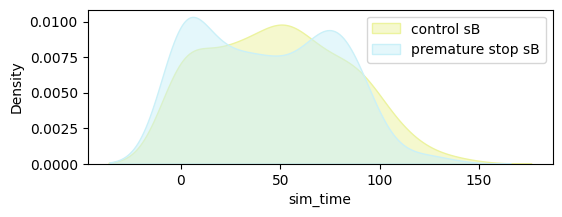

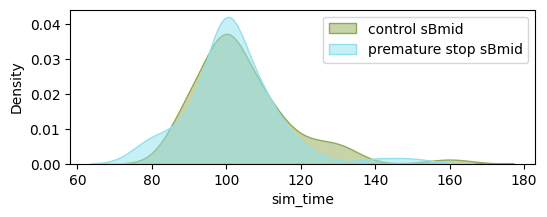

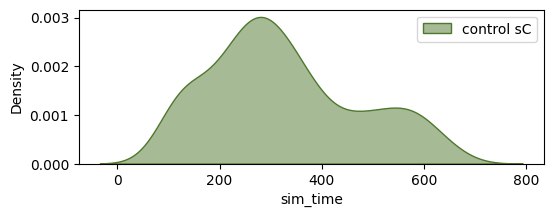

In [69]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(clin, "sB", colors = ["#ecf39e", "#caf0f8"], time_column="sim_time")
    comp_kde(clin, "sBmid", colors = ["#90a955", "#90e0ef"], time_column="sim_time")
    
    kdeplot2(clin, "control", "sC", milestone_column = "milestones", color="#4f772d", time="sim_time")
    kdeplot2(clin, "premature stop", "sC_batch", milestone_column = "milestones", color="#00b4d8", time="sim_time")
    kdeplot2(clin, "control", "sEndC", milestone_column = "milestones", color="#31572c",  time="sim_time")
    plt.legend()

In [70]:
scgen2_result

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'X'
    obsp: 'connectivities', 'distances'

## Between orig & after

In [71]:
clin_after = clin
dlin_after = dlin

# select all where linC is True
clin_before = scgen2_result[scgen2_result.obs.linC == "TRUE"]
dlin_before = scgen2_result[scgen2_result.obs.linD == "TRUE"]


In [72]:
clin_before

View of AnnData object with n_obs × n_vars = 1186 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'X'
    obsp: 'connectivities', 'distances'

In [75]:
cbx, cby, cbkde = get_kde_eval(norm(clin_before.obs.orig_linC_pseudotime), bandwith=0.1)
dbx, dby, dbkde = get_kde_eval(norm(dlin_before.obs.orig_linD_pseudotime), bandwith=0.1)

cax, cay, cakde = get_kde_eval(norm(clin_after.obs.slingPseudotime_2), bandwith=0.1)
dax, day, dakde = get_kde_eval(norm(dlin_after.obs.slingPseudotime_1), bandwith=0.1)

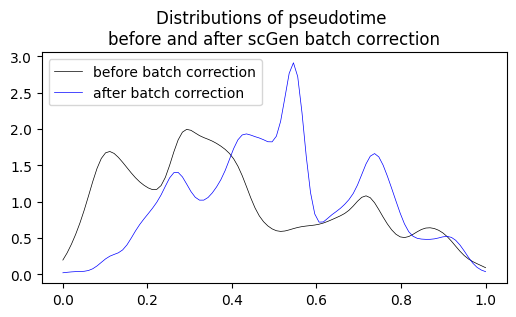

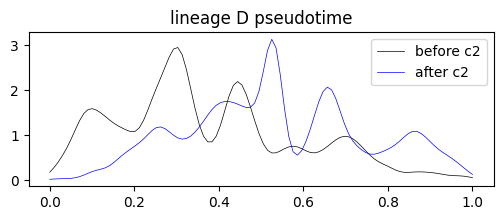

In [84]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.plot(cbx, cby, color="black", lw=0.5, label="before batch correction")
ax.plot(cax, cay, color="blue", lw=0.5, label="after batch correction")
plt.title("Distributions of pseudotime \nbefore and after scGen batch correction")
plt.legend()
plt.show()
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(dbx, dby, color="black", lw=0.5, label="before c2")
ax.plot(dax, day, color="blue", lw=0.5, label="after c2")
plt.title("lineage D pseudotime")
plt.legend()
plt.show()

In [79]:
c_wasserstein = scipy.stats.wasserstein_distance(cbx, cax, cby, cay)
print(f"Wasserstein distance before vs after C: {c_wasserstein}")
d_wasserstein = scipy.stats.wasserstein_distance(dbx, dax, dby, day)
print(f"Wasserstein distance before vs after D: {d_wasserstein}")

Wasserstein distance before vs after C: 0.11013402754600837
Wasserstein distance before vs after D: 0.16240993114125876
